# TP d'optimisation
## Méthodes d'optimisation pour la régression logistique pénalisée lasso

On veut comparer les algorithmes ISTA, FISTA, ADMM et SGD sur la régression logistique pénalisée lasso.

On considère que l'on observe les couples $(y_i,X_i)$ avec $y_i \in \{ -1, 1\}$ et $X_i \in \mathbb R^p$ dont la vraisemblance au point $\beta \in \mathbb R^p$ est donnée par 
$$
\prod_{i=1}^n \frac{1}{1+\exp(-y_i X_i \beta)}.
$$

On veut donc résoudre
$$
\arg\min_\beta \frac{1}{n}\sum_{i=1}^n \log\big(1 + \exp(-y_i X_i \beta) \big)+  \lambda\| \beta \|_{\ell_1}
$$



## Simulation dans un modèle logistique

### Choix des valeurs de $n$ et $p$

In [5]:
n_features = 50
n_samples = 2000

### Choix des valeurs de $\beta^\star$

On pose $\beta^\star_j = (-1)^{j-1} \exp(-(j-1)/10)$.

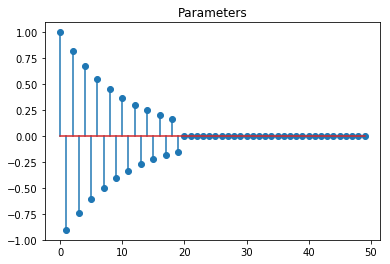

In [7]:
import numpy as np
import matplotlib.pylab as plt

%matplotlib inline

idx = np.arange(n_features)
params = (-1) ** idx  * np.exp(-idx / 10.)
params[20:] = 0.
plt.stem(params)
plt.title("Parameters")

### Simulation de la matrice X (features)

In [8]:

from numpy.random import multivariate_normal
from scipy.linalg.special_matrices import toeplitz

# Correlation
rho = 0.1
# Matrice de covariance Toeplitz

np.set_printoptions(precision=2) # pour simplifier l'affichage
cov = toeplitz(rho ** np.arange(0, n_features))

# Simulation d'un vecteur gaussien de taille n avec cette matrice de covariance
features = multivariate_normal(np.zeros(n_features), cov, size=n_samples)

### Simulations des $y_i$

Coder une fonction **sigmoïd**. Attention aux overflows possibles !

Coder une fonction **simu_log_reg** qui pour $n$, $\beta^\star$ et $\rho$ renvoie une matrice de features et un vecteur de labels.

In [12]:
from numpy.random import binomial

In [13]:
def simu_logreg(n_samples,params=params,rho=0.1):
    """ simulation in a logistic regression model 
    
    Parameters
    ----------
    coefs : `numpy.array`, shape=(n_features,)
        Coefficients of the model
    n_samples : `int`, 
        Number of samples to simulate
    rho : `float`, default=0.1
        Correlation of the features
    Returns
    -------
    X : `numpy.ndarray`, shape=(n_samples, n_features)
    Simulated features matrix. It samples of a centered Gaussian
    vector with covariance given by the Toeplitz matrix
    y : `numpy.array`, shape=(n_samples,)
                 Simulated labels
    """
    n_features = params.size
    
    cov = toeplitz(rho ** np.arange(0, n_features))
    
    features = multivariate_normal(np.zeros(n_features), cov, size=n_samples)
    
    pis = sigmoid(features.dot(params))
    
    labels = 2 * ( binomial(1,pis, n_samples) - 1)
    
    return((features,labels))

In [23]:
X,y = simu_logreg(2000)
print(y.shape)
print(X.shape)

(2000,)
(2000, 50)


## Objectif, gradient sans lasso (quand $\lambda=0$)

- Coder une fonction qui calcule la perte logistique et son gradient pour une matrice de features $X$, un vecteur de labels $y$ et une valeur courante $w$ du paramètre
- Vérifier qu'il n'y pas d'erreur en utilisant la fonction **check_grad** de scipy.optimize
- Coder une fonction qui calcule l'objectif

In [24]:
def loss_logreg(w,X,y):
    """ calcul de la perte logistique
     Parameters
    ----------
    X : `numpy.array`, shape=(n_samples,n_features)
        features
    y : `numpy.array`, shape=(n_samples,)
        labels
    w : `numpy.array`, shape=(n_features,)
        value of the parameter
    """
    return 

In [26]:
def grad_logreg(w,X,y):
    """ calcul du gradient de la perte logistique
         Parameters
    ----------
    X : `numpy.array`, shape=(n_samples,n_features)
        features
    y : `numpy.array`, shape=(n_samples,)
        labels
    w : `numpy.array`, shape=(n_features,)
        value of the parameter
    """

    return

In [28]:
from scipy.optimize import check_grad
print(check_grad(loss_logreg, grad_logreg, params,X,y))

3.0740654579e-08


In [31]:
def objective(X,y,w):
    return(loss_logreg(X,y,w))

On met le tout dans une classe comme indiqué ci-dessous

In [36]:
from numpy.linalg import norm
class Logreg:
    """       
    Parameters
    ----------
    X : `numpy.array`, shape=(n_samples,n_features)
        features
    y : `numpy.array`, shape=(n_samples,)
        labels
    lamb : `float`, 
        value of the regularization parameter
    """
    def __init__(self,X,y,lamb):
        self.X = X
        self.y = y
        self.lamb = lamb
        self.n_samples, self.n_features = X.shape

    def loss(self,w):
        u = self.y * self.X.dot(w) 
        return -np.sum(np.log(sigmoid(u))) / self.n_samples

    def grad(self,w):
        u = self.y * self.X.dot(w) 
        return self.X.T.dot(self.y  * (sigmoid(u) - 1)) / self.n_samples

    def objective(self,w):
        return(self.loss_logreg(w))


In [37]:
model_logreg = Logreg(X,y,0.1)
model_logreg.grad(np.zeros(n_features))
model_logreg.lip_const()

0.36070596251326198

In [39]:
print(check_grad(model_logreg.loss, model_logreg.grad, params))

3.0740654579e-08


# Descente de gradient et algorithme de Newton

- Coder l'algorithme de descente de gradient, il faut ajouter une méthode **lip_const** qui calcule une constante de Lipschitz pour le gradient.
- Coder l'algorithme de Newtow, il faudra ajouter une méthode **hessian** à la classe logreg.
- Représenter l'évolution des objectifs graphiquement

In [40]:
def gd(model, w0, step = None, n_iter=50, verbose=True):
    """
    Gradient descent
    """
    w = w0.copy()
    w_new = w0.copy()
    n_samples, n_features = model.X.shape
    # objective history
    objectives = []
    # Current objective
    obj = model.loss(w) 
    objectives.append(obj) 
    if verbose:
        print("Lauching GD solver...")
        print(' | '.join([name.center(8) for name in ["it", "obj"]])) 
    for k in range(n_iter + 1):
        if step==None:
            step = 1/model.lip_const()
    #######################################################################
        w_new[:] =
        w[:] = w_new
    #######################################################################
        obj = model.loss(w) 
        objectives.append(obj)
        if k % 10 == 0 and verbose:
            print(' | '.join([("%d" % k).rjust(8), ("%.2e" % obj).rjust(8)]))
    return w, np.array(objectives)

In [53]:
def newton(model, w0, n_iter=50, verbose=True):
    """
    Newton algorithm
    """
    w = w0.copy()
    w_new = w0.copy()
    n_samples, n_features = model.X.shape
    # objective history
    objectives = []
    # Current objective
    obj = model.loss(w) 
    objectives.append(obj) 
    if verbose:
        print("Lauching GD solver...")
        print(' | '.join([name.center(8) for name in ["it", "obj"]])) 
    for k in range(n_iter + 1):
    #######################################################################
        w_new[:] = 
        w[:] = w_new
    #######################################################################
        obj = model.loss(w) 
        objectives.append(obj)
        if k % 10 == 0 and verbose:
            print(' | '.join([("%d" % k).rjust(8), ("%.2e" % obj).rjust(8)]))
    return w, np.array(objectives)

In [54]:
w0 = np.zeros(n_features)
n_iter = 60
import time
w_gd , obj_gd = gd(model_logreg,w0)
start = time.time()
w_newton, obj_newton =newton(model_logreg,w0)
end = time.time()
print(end - start)


Lauching GD solver...
   it    |   obj   
       0 | 2.73e+00
      10 | 5.75e-01
      20 | 5.55e-01
      30 | 5.54e-01
      40 | 5.54e-01
      50 | 5.54e-01
Lauching GD solver...
   it    |   obj   
       0 | 1.55e+00
      10 | 5.54e-01
      20 | 5.54e-01
      30 | 5.54e-01
      40 | 5.54e-01
      50 | 5.55e-01
1.0465288162231445


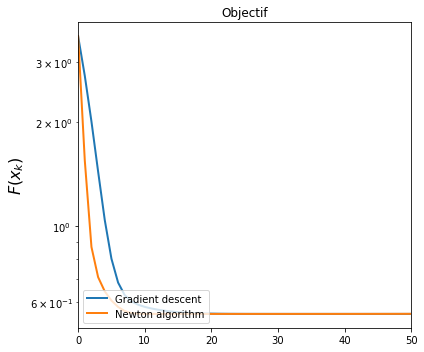

In [55]:
plt.figure(figsize=(6, 5))
plt.yscale("log")
plt.plot(obj_gd , label="Gradient descent", lw=2) 
plt.plot(obj_newton , label="Newton algorithm", lw=2) 
#plt.plot(obj_agd - obj_opt, label="AGD", lw=2) 
#plt.plot(obj_cd - obj_opt, label="CD", lw=2) 
#plt.plot(obj_cgd - obj_opt, label="CGD", lw=2) plt.xlabel(r"$k$", fontsize=16)
plt.ylabel(r"$F(x_k)$", fontsize=16) 
plt.legend(loc='lower left')
plt.title('Objectif')
plt.xlim((0, n_iter))
plt.tight_layout()
#plt.savefig('gd_agd_cgd.pdf')

# Descente de gradient proximal

On retourne au cas de la régression logistique pénalisée lasso.

- Faire une nouvelle classe **logreg_l1** sur le modèle de la classe **logreg** en ajoutant un méthode  qui calcule l'opérateur proximal de la norme 1 et en changeant la méthode objectif

In [56]:
from numpy.linalg import norm
class Logreg_l1:
    """       
    Parameters
    ----------
    X : `numpy.array`, shape=(n_samples,n_features)
        features
    y : `numpy.array`, shape=(n_samples,)
        labels
    lamb : `float`, 
        value of the regularization parameter
    """
    def __init__(self,X,y,lamb):
        self.X = X
        self.y = y
        self.lamb = lamb
        self.n_samples, self.n_features = X.shape

    def loss(self,w):
        u = self.y * self.X.dot(w) 
        return -np.sum(np.log(sigmoid(u))) / self.n_samples

    def grad(self,w):
        u = self.y * self.X.dot(w) 
        return self.X.T.dot(self.y  * (sigmoid(u) - 1)) / self.n_samples

    def pen(self,w):
        
    
    def prox(self,w,step):
        

    def objective(self,w):
        return(self.loss_logreg(w) + self.pen_l1(w))
  

In [57]:
X,y = simu_logreg(2000)
lamb=0
print(y.shape)
print(X.shape)
model_logreg_l1 = Logreg_l1(X,y,lamb)

(2000,)
(2000, 50)


In [58]:
print(check_grad(model_logreg_l1.loss, model_logreg_l1.grad, params))

3.31780718702e-08


Coder une fonction **pgd** qui code l'algorithme descente de gradient proximal (sur le modèle de la fonction **gd**).

In [59]:
def pgd(model, w0, step = None, n_iter=50, verbose=True):
    """Proximal gradient descent
    """
    w = w0.copy()
    w_new = w0.copy()
    n_samples, n_features = model.X.shape
    # objective history
    objectives = []
    # Current objective
    obj = model.loss(w) 
    objectives.append(obj) 
    if verbose:
        print("Lauching GD solver...")
        print(' | '.join([name.center(8) for name in ["it", "obj"]])) 
    for k in range(n_iter + 1):
        if step == None:
            step = 1 / (model.lip_const())
    #######################################################################
        w_new[:] = 
        w[:] = w_new
    #######################################################################
        obj = model.loss(w) 
        objectives.append(obj)
        if k % 10 == 0 and verbose:
            print(' | '.join([("%d" % k).rjust(8), ("%.10e" % obj).rjust(8)]))
    return w, np.array(objectives)

In [61]:
w0 = np.zeros(n_features)
n_iter = 60
w_pgd , obj_pgd = pgd(model_logreg_l1,w0,n_iter=50)

Lauching GD solver...
   it    |   obj   
       0 | 5.6169312190e-01
      10 | 5.3936977497e-01
      20 | 5.3918130111e-01
      30 | 5.3917490474e-01
      40 | 5.3917466102e-01
      50 | 5.3917465154e-01


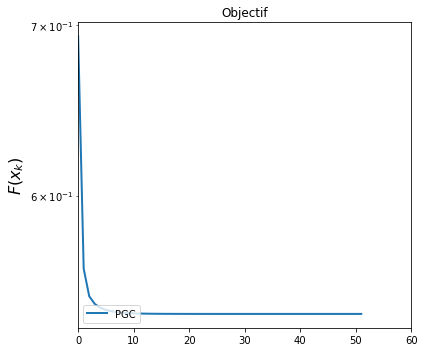

In [62]:
plt.figure(figsize=(6, 5))
plt.yscale("log")
plt.plot(obj_pgd , label="PGC", lw=2) 
#plt.plot(obj_agd - obj_opt, label="AGD", lw=2) 
#plt.plot(obj_cd - obj_opt, label="CD", lw=2) 
#plt.plot(obj_cgd - obj_opt, label="CGD", lw=2) plt.xlabel(r"$k$", fontsize=16)
plt.ylabel(r"$F(x_k)$", fontsize=16) 
plt.legend(loc='lower left')
plt.title('Objectif')
plt.xlim((0, n_iter))
plt.tight_layout()
#plt.savefig('gd_agd_cgd.pdf')

Coder un arrêt prematuré quand $tol = 1e-03 > \|w_{\text{new}} - w\|/\|w\|$

In [63]:
def pgd2(model, w0,  step = None,n_iter=50, verbose=True,tol=1e-02):
    """Proximal gradient descent
    """
    w = w0.copy()
    w_new = w0.copy()
    n_samples, n_features = model.X.shape
    # objective history
    objectives = []
    # Current objective
    obj = model.loss(w) 
    objectives.append(obj) 
    if verbose:
        print("Lauching GD solver...")
        print(' | '.join([name.center(8) for name in ["it", "obj"]])) 
    for k in range(n_iter + 1):
         if step == None:
            step = 1 / (10* model.lip_const())
    #######################################################################
        w_new[:] = 
        w[:] = w_new
    #######################################################################
        obj = model.loss(w) 
        objectives.append(obj)
        if k % 10 == 0 and verbose:
            print(' | '.join([("%d" % k).rjust(8), ("%.2e" % obj).rjust(8)]))
    return w, np.array(objectives)

In [64]:
w_pgd2 , obj_pgd2 = pgd2(model_logreg_l1,w0)

Lauching GD solver...
   it    |   obj   
       0 | 6.67e-01
      10 | 5.77e-01
      20 | 5.58e-01
      30 | 5.50e-01


/Users/agatheguilloux/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in double_scalars


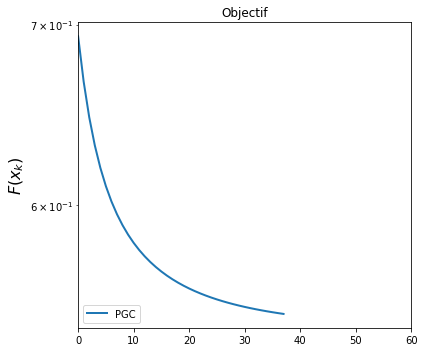

In [65]:
plt.figure(figsize=(6, 5))
plt.yscale("log")
plt.plot(obj_pgd2 , label="PGC", lw=2) 
#plt.plot(obj_agd - obj_opt, label="AGD", lw=2) 
#plt.plot(obj_cd - obj_opt, label="CD", lw=2) 
#plt.plot(obj_cgd - obj_opt, label="CGD", lw=2) plt.xlabel(r"$k$", fontsize=16)
plt.ylabel(r"$F(x_k)$", fontsize=16) 
plt.legend(loc='lower left')
plt.title('Objectif')
plt.xlim((0, n_iter))
plt.tight_layout()
#plt.savefig('gd_agd_cgd.pdf')

# Descente de gradient stochastique proximal

In [ ]:
- Coder un algorithme de descente de gradient stochastique proximal pour ce problème
- Comparer ses performances au PGD classique

# ADMM 

In [ ]:
- Coder un algorithme ADMM pour ce problème
- Comparer ses performances au PGD classique et au SPGD